# Iterative Deepening A* (IDA*) Algorithm 

The requirement to store the `A*` search tree in memory (`Closed` and `Open` sets) can become a limiting factor for certain problems. The renowned **n-puzzle** (or Gem Puzzle) game is a prime example, particularly when $n > 3$. A potential solution to this challenge is to combine the iterative deepening technique with A*. This approach is known as the IDA* algorithm [(Korf, 1985)](https://academiccommons.columbia.edu/doi/10.7916/D8BK1M9V/download).

In this lab, your task is to implement the `IDA*` algorithm for the n-puzzle game and then contrast its performance with `A*`, focusing primarily on runtime and memory usage metrics. To commence, you will need to create your own benchmark.

Best of luck!

(Korf, 1985) Korf, R.E., 1985. Depth-first iterative-deepening: An optimal admissible tree search. Artificial intelligence, 27(1), pp.97-109. [[PDF](https://academiccommons.columbia.edu/doi/10.7916/D8BK1M9V/download)]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
from typing import Tuple, List, Iterable, Callable, Type, Dict, Union, Optional, Set
import numpy.typing as npt

%matplotlib inline

STEP_COST = 1

## Gem Puzzle (15-puzzle or n-puzzle)
### Representation of a search state

Indeed, there may exist many ways to represent a search state for the Gem Puzzle. In this lab, we will use a list of integers as an external encoding of the Gem Puzzle state. This list is assumed to contain numbers from 1 to (*size* * *size*), where *size* is the size of the puzzle. The tile with the number *size* * *size* is a blank tile.

For example, the encoding of the start state of the 8-puzzle depicted above will be \[7,2,4,5,9,6,8,3,1\].

In [3]:
from utils.gem_puzzle import GemPuzzleState

help(GemPuzzleState)

Help on class GemPuzzleState in module utils.gem_puzzle:

class GemPuzzleState(builtins.object)
 |  GemPuzzleState(tile_list: Optional[List[int]] = None)
 |
 |  Implementing a search state (or simply, a state) in code is a crucial first step
 |  necessary for tackling any search problem. The `GemPuzzleState` class is structured
 |  with the following fields:
 |
 |  Attributes
 |  ----------
 |  size : int
 |      Width of the game field.
 |
 |  tile_list : Optional[List[int]]
 |      Tile positions represented as a list of integers from 1 to (size x size).
 |      Each integer corresponds to a tile's value, and its index represents its position
 |      on the game field. The tile with the maximum value is considered the blank.
 |
 |  parent : GemPuzzleState
 |      A pointer to the parent state. The parent is a predecessor of the state in
 |      the search tree. It is used to reconstruct a path to that state from the start
 |      state (the root of the search tree).
 |
 |  blank_pos 

### Get Succesors

In [4]:
from utils.gem_puzzle import get_successors

help(get_successors)

Help on function get_successors in module utils.gem_puzzle:

get_successors(state: utils.gem_puzzle.GemPuzzleState) -> List[utils.gem_puzzle.GemPuzzleState]
    Implementing the `get_successors` function is another crucial step in tackling any search problem.
    This function is designed to take a specific search state as input and return all possible successor states,
    which result from applying all applicable actions to the input state. In the case of GemPuzzle, the successors
    correspond to the board states resulting from moving the blank tile up, down, left, or right. If the blank tile
    goes out of the field after a move, such a successor should be discarded.

    Parameters
    ----------
    state : GemPuzzleState
        The input search state.

    Returns
    -------
    List[GemPuzzleState]
        A list containing all possible successor states for the input state.



## Heuristics Search Implementation

### Search Node

A Search node is a fundamental concept in heuristic search algorithms. It encapsulates data about the state of the problem (e.g., the position of a robot or agent on a grid) and the information needed to construct a search tree, including g-values, h-values, f-values, and a backpointer to its predecessor.


In [5]:
class Node:
    """
    Initializes a search node.

    Parameters
    ----------
    state : GemPuzzleState
        Game state which corresponds to the current node.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node (always 0 for Dijkstra).
    f : float | int
        f-value of the node (always equal to g-value for Dijkstra).
    parent : Node
        Pointer to the parent node.
    """

    def __init__(self, state, g=0, h=0, f=None, parent=None):
        self.state = state
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

 

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        # <YOUR CODE GOES HERE>
        return self.state == other.state

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        # <YOUR CODE GOES HERE>
        return hash(self.state)

    def __str__(self):
        """
        Converts corrsponding game state to formatted string
        """
        return str(self.state)

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        # <YOUR CODE GOES HERE>
        return self.f < other.f

### Implementing the Search Tree (i.e. OPEN and CLOSED)

Efficient implementation of the search tree (`Open` and `Closed`) is crucial for `A*` search algorithm. You should use your efficient implementation of the search tree that you've created in the previous lab.

In [6]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        # <YOUR CODE GOES HERE>
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        # <YOUR CODE GOES HERE>
        best_node = None
        while not self.open_is_empty():
            node=heappop(self._open)
            if not self.was_expanded(node):
                best_node = node
                break
            self._enc_open_duplicates += 1
        return best_node


    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        # <YOUR CODE GOES HERE>
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        # <YOUR CODE GOES HERE>
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

### Heuristics

You need to implement 2 most common *admissible* heuristic functions for the n-puzzle.
- Hamming distance (the number of the misplaced tiles on the board)
- Manhattan distance (the sum of manhatten distances for each tile).

In [7]:
def hamming_distance(state1: GemPuzzleState, state2: GemPuzzleState) -> int:
    """
    Implementation of Hamming heuristic.
    The blank tile is not checked when calculating the Hamming distance.

    Parameters
    ----------
    state1 : GemPuzzleState
        Representation of the first state.
    state2 : GemPuzzleState
        Representation of the second state.

    Returns
    ----------
    int
        Hamming distance between two states.
    """
    blank_value = state1.size**2
    return sum(state1.tile_list[i]!=state2.tile_list[i] for i in range(blank_value) if state2.tile_list[i]!=blank_value ) 


In [42]:
def dist(a:int, b:int, size:int):
    a_row = a / size
    a_col= a % size
    b_row = b / size
    b_col = b % size

    return abs(a_row - b_row) + abs(a_col - b_col)


def manhattan_distance(state1: GemPuzzleState, state2: GemPuzzleState) -> int:
    """
    Computes the Manhattan distance between two Gem Puzzle states. 
    The blank tile is not checked when calculating the Manhattan distance.

    Parameters
    ----------
    state1 : GemPuzzleState
        Representation of the first state.
    state2 : GemPuzzleState
        Representation of the second state.

    Returns
    ----------
    int
        Manhattan distance between two states.
    """


    blank_value = state1.size**2

    distance = sum(dist(state1.tile_list.index(i),state2.tile_list.index(i),state1.size) for i in range(1, blank_value))
    return distance

### A* Algorithm

Adapt the A* algorithm for the gem puzzle and for forthcoming experiments.

The input of `A*` algorithm should be:
- start/goal states
- heuristic function
- the reference to the implementation of the search tree

The output of the algorithm should be:
- path found flag (`True` or `False`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)

In [16]:
def astar(
    start_state: GemPuzzleState, goal_state: GemPuzzleState, heuristic_func: Callable, search_tree: Type[SearchTreePQD]
) -> Tuple[bool, Optional[Node], int, int]:
    """
    Implementation of A* algorithm.
    """

    ast = search_tree()  # A* search tree
    steps = 0
    search_tree_size = 0

    start_node = Node(start_state, g=0, h=heuristic_func(start_state, goal_state))
    ast.add_to_open(start_node)

    flag = False
    # <YOUR CODE GOES HERE>
    node = None

    while not ast.open_is_empty():
        node = ast.get_best_node_from_open()
        if node is None:
            break

        steps += 1
        ast.add_to_closed(node)
        if node.state==goal_state:
            flag = True
            break
        for succ in get_successors(node.state):
            g = node.g + STEP_COST
            succ_node = Node(succ, g, h=heuristic_func(succ, goal_state), parent=node)

            if not ast.was_expanded(succ_node):
                ast.add_to_open(succ_node)

    search_tree_size = len(ast)
    print(flag)
    return flag, node, steps, search_tree_size

### IDA* Algorithm

Implement the IDA* algorithm.

- Only nodes that form the current path in the search tree need to be retained.
- It's acceptable to check if the generated successors have already been encountered on the currently explored path.
- The input and output formats of the algorithm should be similar to `A*`.

In [ ]:
def recursive_search(
    curr_node: Node,
    goal_state: GemPuzzleState,
    bound: Union[int, float],
    path: Set[Node],
    steps: int,
    heuristic_func: Callable,
) -> Tuple[bool, int, Optional[Node], Set[Node], int]:
    """
    Implementation of IDA* recursive procedure.
    """
    steps += 1
    # <YOUR CODE GOES HERE>
    if curr_node.f > bound:
        return False, curr_node.f, None, path, steps
    
    if curr_node.state == goal_state:
        return True, 0, curr_node, path, steps
    
    min_exceeded = float("inf")

    for succ in get_successors(curr_node.state):
        adj_node = Node(succ, g=curr_node.g+STEP_COST, h=heuristic_func(succ, goal_state))
        adj_node.parent = curr_node

        if adj_node in path:
            continue

        path.add(adj_node)
        found, new_bound, result_node, updated_path, steps = recursive_search(adj_node, goal_state, bound, path, steps, heuristic_func)
        if found:
            return True, 0, result_node, updated_path, steps
        
        if new_bound < min_exceeded:
            min_exceeded = new_bound

        path.discard(adj_node)

    return False, min_exceeded, None, path, steps

def idastar(
    start_state: GemPuzzleState, goal_state: GemPuzzleState, heuristic_func: Callable
) -> Tuple[bool, Optional[Node], int, int]:
    """
    Implementation of IDA* algorithm.
    """
    bound = heuristic_func(start_state, goal_state)
    root = Node(start_state, g=0, h=bound)
    steps = 0
    path = {root}
    
    while True:
    
        found, new_bound, result_node, updated_path, steps = recursive_search(root, goal_state, bound, path, steps, heuristic_func)
        
        if found:
            print(True)
            return True, result_node, steps, len(path)
        
        if new_bound == float("inf"):
            #print(False)
            return False, None, steps, len(path)
            
        bound = new_bound

## Experiment

### Create Dataset

For this task, you are required to create your own test dataset and utilize it in the experiments.

Sample instances can be found in `data/tasks_gem.txt`.

You must generate and add at least 30 more instances (specifically, 8-puzzles) to the file for the experimental runs. Random generation is an option. If you choose to generate puzzles randomly, remember to check the solvability of each instance. It's important to note that not all n-puzzles are solvable.


In [12]:
from utils.dataset_creation import generate_tasks

In [13]:
# Use it only once
generate_tasks("data/tasks_gem.txt", 30, 3)

2 4 5 1 8 6 7 9 3 Manhattan distance 9
9 3 5 7 1 6 4 2 8 Manhattan distance 10
7 6 9 1 2 3 8 5 4 Manhattan distance 12
3 1 2 9 8 5 7 6 4 Manhattan distance 11
5 9 6 1 8 3 4 2 7 Manhattan distance 11
2 4 6 7 9 3 5 8 1 Manhattan distance 12
7 3 1 5 9 8 4 2 6 Manhattan distance 12
1 8 3 2 7 4 9 5 6 Manhattan distance 10
3 1 8 5 2 6 4 7 9 Manhattan distance 10
6 2 9 1 7 5 4 3 8 Manhattan distance 12
9 3 1 6 8 5 4 2 7 Manhattan distance 12
3 4 6 5 9 1 7 2 8 Manhattan distance 12
1 6 9 7 5 4 8 3 2 Manhattan distance 12
2 3 4 6 7 5 1 8 9 Manhattan distance 12
6 3 5 4 2 1 8 7 9 Manhattan distance 12
1 2 4 5 9 6 7 3 8 Manhattan distance 8
7 1 6 5 3 4 8 2 9 Manhattan distance 12
1 2 3 4 5 7 8 9 6 Manhattan distance 5
7 3 2 1 9 4 6 5 8 Manhattan distance 12
7 6 3 9 5 4 1 2 8 Manhattan distance 11
4 5 8 1 2 9 7 6 3 Manhattan distance 11
7 1 3 5 2 8 9 6 4 Manhattan distance 12
4 6 3 1 9 8 2 5 7 Manhattan distance 12
2 4 1 9 8 5 7 3 6 Manhattan distance 11
2 8 1 7 5 6 9 4 3 Manhattan distance 10
7 3

It is convenient to have a procedure that accepts both a search algorithm and a heuristic function (e.g., `IDA*` + Manhattan distance) as parameters, runs tests, and saves the results for subsequent analysis.

The `massive_test` function presumes that the search function adheres to the following template:

```
search(start_state, goal_state, *optional arguments*) -> (path_found, last_state, steps, search_tree_size)
```
where
- `start_state/goal_state` — start and goal states, in the form of `GemPuzzleState` 
- `*optional arguments*` — additional parameters of the search function, passed usin `*args`. For instance, the heuristic function.
- `path_found` — `True` if path was found, `False` otherwise
- `last_state` — last state of the path. `None` if path was not found
- `steps` —  the number of search steps
- `search_tree_size` — the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)

In [14]:
from tests.lab_test import massive_test

### Run Tests
Run `A*` and `IDA*` with different heuristics on the generated instances and collect the results for further analysis.

In [52]:
%time astar_manh_stat = massive_test(astar, 'data/tasks_gem.txt', manhattan_distance, SearchTreePQD)

True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
CPU times: user 2.25 s, sys: 0 ns, total: 2.25 s
Wall time: 2.28 s


In [53]:
%time astar_hamm_stat = massive_test(astar, 'data/tasks_gem.txt', hamming_distance, SearchTreePQD)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 9.96 s


In [54]:
%time idastar_manh_stat = massive_test(idastar, 'data/tasks_gem.txt', manhattan_distance)

CPU times: user 23.2 s, sys: 0 ns, total: 23.2 s
Wall time: 23.6 s


In [55]:
%time idastar_hamm_stat = massive_test(idastar, 'data/tasks_gem.txt', hamming_distance)

CPU times: user 43.6 s, sys: 0 ns, total: 43.6 s
Wall time: 43.2 s


Finally, try to measure the real time/memory consumption on certain instances.

In [46]:
# to measure the memory consumtion in absolute values you can use the 'memory_profiler'
# package (you may need installation)

#!pip install -U memory_profiler
%reload_ext memory_profiler

In [47]:
start_tile_list_str = "1 2 10 8 12 14 6 4 15 13 5 3 9 7 11 16"  # You can try a harder instance if you like
start_tile_list = list(map(int, start_tile_list_str.split()))
goal_tile_list = list(range(1, len(start_tile_list) + 1))
start_state = GemPuzzleState(start_tile_list)
goal_state = GemPuzzleState(goal_tile_list)

In [48]:
%%time
%memit idastar(start_state, goal_state, manhattan_distance)

peak memory: 189.25 MiB, increment: 0.00 MiB
CPU times: user 4min 40s, sys: 23.6 ms, total: 4min 40s
Wall time: 4min 41s


In [35]:
%%time
%memit astar(start_state, goal_state, manhattan_distance, SearchTreePQD)

True
peak memory: 991.88 MiB, increment: 844.75 MiB
CPU times: user 53.8 s, sys: 2 s, total: 55.8 s
Wall time: 58.9 s


### Results Analisys 
Analyze the obtained results and vizualize them as plots/tables. Write a short report in the separate cell.

In [56]:
eq_tasks = (
    (astar_hamm_stat["len"] == astar_manh_stat["len"])
    & (astar_hamm_stat["len"] == idastar_manh_stat["len"])
    & (astar_hamm_stat["len"] == idastar_hamm_stat["len"])
)

eq_tasks_num = np.sum(eq_tasks)
all_tasls_num = len(astar_manh_stat["len"])
print("The path lengths are the same in", (eq_tasks_num / all_tasls_num) * 100, "% of cases")

astar_manh_mem = astar_manh_stat["st_size"].mean()
astar_hamm_mem = astar_hamm_stat["st_size"].mean()
idastar_manh_mem = idastar_manh_stat["st_size"].mean()
idastar_hamm_mem = idastar_hamm_stat["st_size"].mean()

astar_manh_steps = astar_manh_stat["steps"].mean()
astar_hamm_steps = astar_hamm_stat["steps"].mean()
idastar_manh_steps = idastar_manh_stat["steps"].mean()
idastar_hamm_steps = idastar_hamm_stat["steps"].mean()

The path lengths are the same in 100.0 % of cases


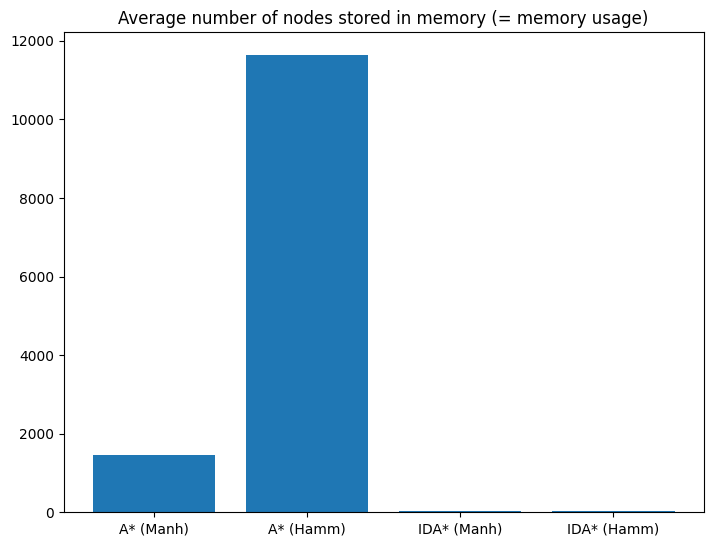

(np.float64(1455.909090909091),
 np.float64(11637.818181818182),
 np.float64(21.242424242424242),
 np.float64(21.242424242424242))

In [57]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Average number of nodes stored in memory (= memory usage)")
alg = ["A* (Manh)", "A* (Hamm)", "IDA* (Manh)", "IDA* (Hamm)"]
mem = [astar_manh_mem, astar_hamm_mem, idastar_manh_mem, idastar_hamm_mem]
ax.bar(alg, mem)
plt.show()

astar_manh_mem, astar_hamm_mem, idastar_manh_mem, idastar_hamm_mem

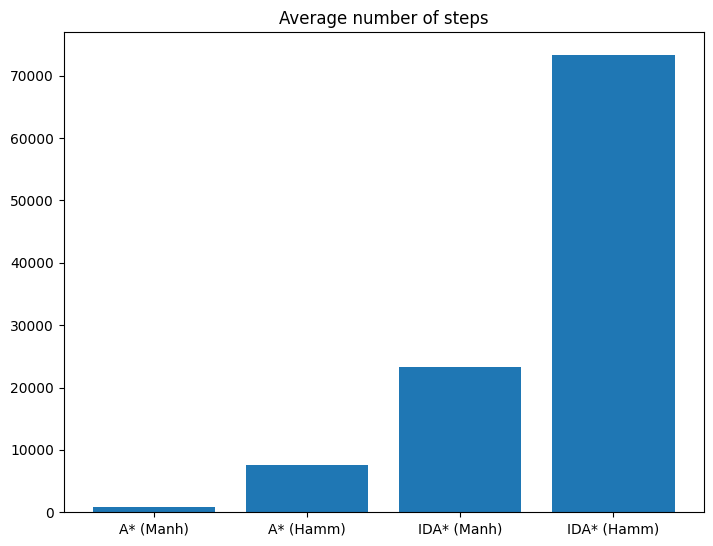

(np.float64(915.3030303030303),
 np.float64(7526.575757575758),
 np.float64(23295.969696969696),
 np.float64(73277.09090909091))

In [51]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Average number of steps")
alg = ["A* (Manh)", "A* (Hamm)", "IDA* (Manh)", "IDA* (Hamm)"]
sts = [astar_manh_steps, astar_hamm_steps, idastar_manh_steps, idastar_hamm_steps]
ax.bar(alg, sts)
plt.show()

astar_manh_steps, astar_hamm_steps, idastar_manh_steps, idastar_hamm_steps

**Your text with analysis here**